#Mengimpor Library

Library yang digunakan untuk pembuatan model NLP (Natural Language Processing) adalah Numpy, Tensorflow, Random dan NTLK.

NLTK merupakan salah satu library tokenizer yang memiliki function 'stemming', yang dapat mengolah kata berimbuhan dan kompleks menjadi kata dasar.

Library pendukung lainnya adalah JSON, Pickle, Warnings dan Curses.

In [18]:
# Library untuk Model
import numpy as np
import tensorflow as tf
import random
import nltk
nltk.download('punkt')
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

# Library pendukung
import json
import pickle
import warnings
import curses

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# Mengecek versi Tensorflow
print(tf. __version__)

2.12.0


#Pengolahan Dataset

Dataset yang digunakan bernama 'intents.json' karena dataset tersebut memiliki data-data yang sudah dilabel (supervised) dengan tagnya masing-masing.
Di dalam 'intents.json' terdapat array 'tag', 'patterns', dan 'responses'.

'tag' merupakan label dari suatu percakapan.
'patterns' merupakan contoh kalimat yang digunakan untuk memprediksi percakapan tersebut.
'responses' merupakan kalimat jadi yang dikirim oleh Chatbot JasaIn secara acak. (Bila terdapat lebih dari satu response)

Setelah diload, dataset response tersebut diolah ke tokenizer sesuai tagnya masing-masing.
Kemudian, kata-kata diubah menjadi kata dasar, huruf kecil, dan dihapus duplikatnya.

In [20]:
print("Memproses dataset intents.....")
with open('./dataset/intents.json') as json_data:
    intents = json.load(json_data)

Memproses dataset intents.....


In [21]:
words = []
classes = []
documents = []
ignore_words = ['?']
print("Mengiterasi isi dataset untuk mengubahnya menjadi words, class, documents, dan ignore_words.......")
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # Tokenisasi tiap kata dalam kalimat
        w = nltk.word_tokenize(pattern)
        # Menambah kata ke dalam array words
        words.extend(w)
        # Menambah dokumen ke dalam korpus (pelatihan/uji)
        documents.append((w, intent['tag']))
        # Menambah tag ke dalam array class
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

Mengiterasi isi dataset untuk mengubahnya menjadi words, class, documents, dan ignore_words.......


In [22]:
print("Meng-stemming, menggunakan huruf kecil dan menghapus duplikat kata.......")
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print ('Ditemukan', len(documents), "dokumen,", len(classes), "class, dan", len(words), "kata unik...")

Meng-stemming, menggunakan huruf kecil dan menghapus duplikat kata.......
Ditemukan 291 dokumen, 33 class, dan 296 kata unik...


Bag of Words merupakan transformasi teks menjadi bilangan biner yang dapat digunakan oleh model training.

In [23]:
print("Membuat data untuk model.....")
training = []
output = []
print("Membuat list kosong untuk output.....")
output_empty = [0] * len(classes)

print("Membuat training set dan Bag of Words ....")
for doc in documents:
    # Inisialisasi Bag of Words
    bag = []
    # Daftar kata-kata yang ditokenisasi untuk pattern
    pattern_words = doc[0]
    # Stem setiap kata
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # Membuat array Bag of Words
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # Outputnya '0' untuk setiap tag dan '1' untuk tag saat ini
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

Membuat data untuk model.....
Membuat list kosong untuk output.....
Membuat training set dan Bag of Words ....


#Membuat Training Set

Sebelum menggunakan dataset untuk training, dataset diacak terlebih dahulu dan diubah menjadi numpy array agar training lebih cepat.

In [24]:
print("Mengacak dan mengubah menjadi numpy array untuk pemrosesan yang lebih cepat......")
random.shuffle(training)
training = np.array(training)

print("Membuat list train.....")
train_x = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

print("Shape train_x:", np.shape(train_x))
print("Shape train_y:", np.shape(train_y))

Mengacak dan mengubah menjadi numpy array untuk pemrosesan yang lebih cepat......
Membuat list train.....
Shape train_x: (291, 296)
Shape train_y: (291, 33)


#Membuat Model Sequential

Model NLP menggunakan Sequential dengan hidden layer yang shape input dan outputnya sesuai dengan shape dataset.

Adakalanya plotting dilakukan untuk memantau model.

Setelah model berhasil dibuat, model dan dataset disimpan.

In [25]:
from tensorflow.keras.initializers import TruncatedNormal

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=(len(train_x[0]),), activation='relu', kernel_initializer=TruncatedNormal()))
model.add(tf.keras.layers.Dense(len(train_y[0]), activation='softmax', kernel_initializer=TruncatedNormal()))

# Kompilasi dan summary model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 2376      
                                                                 
 dense_3 (Dense)             (None, 33)                297       
                                                                 
Total params: 2,673
Trainable params: 2,673
Non-trainable params: 0
_________________________________________________________________


In [26]:
import matplotlib.pyplot as plt

# Melakukan fitting dan mendapatkan history dari fitting model
print("Melakukan training model.......")
history = model.fit(train_x, train_y, batch_size=8, epochs=200)

Melakukan training model.......
Epoch 1/200
37/37 [==============================] - 0s 1ms/step - loss: 3.4947 - acc: 0.0447 
Epoch 2/200
37/37 [==============================] - 0s 1ms/step - loss: 3.4830 - acc: 0.1168
Epoch 3/200
37/37 [==============================] - 0s 955us/step - loss: 3.4629 - acc: 0.1203
Epoch 4/200
37/37 [==============================] - 0s 1ms/step - loss: 3.4262 - acc: 0.1306
Epoch 5/200
37/37 [==============================] - 0s 1ms/step - loss: 3.3721 - acc: 0.1100
Epoch 6/200
37/37 [==============================] - 0s 1ms/step - loss: 3.3023 - acc: 0.1100
Epoch 7/200
37/37 [==============================] - 0s 1ms/step - loss: 3.2218 - acc: 0.0653
Epoch 8/200
37/37 [==============================] - 0s 1ms/step - loss: 3.1373 - acc: 0.0687
Epoch 9/200
37/37 [==============================] - 0s 1ms/step - loss: 3.0520 - acc: 0.0893
Epoch 10/200
37/37 [==============================] - 0s 1ms/step - loss: 2.9681 - acc: 0.1203
Epoch 11/200
37/37 [====

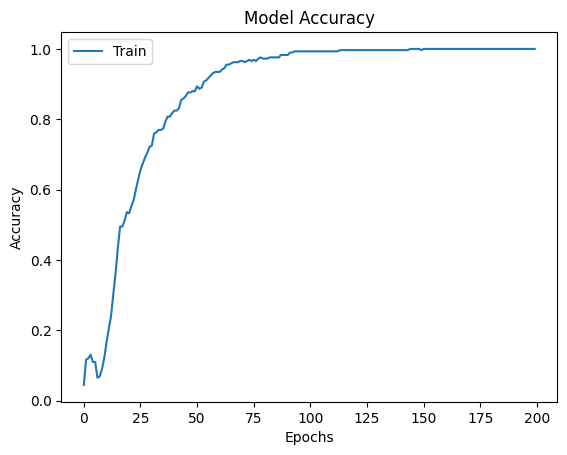

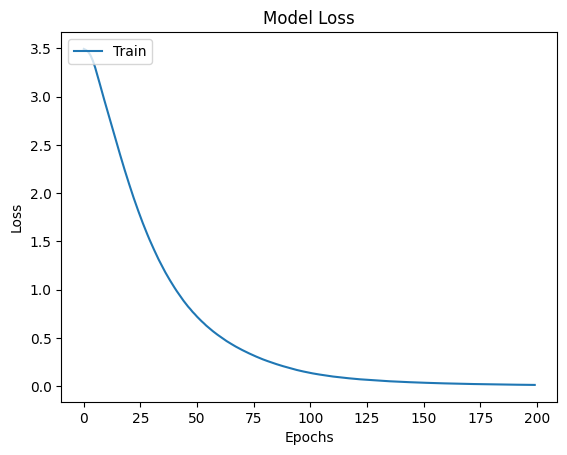

In [27]:
# Memplot akurasi (accuracy)
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()

# Memplot loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')
plt.show()

In [28]:
# Menyimpan model dan pickle
print("Melakukan save model.......")
model.save('model.h5')

print("Melakukan save pickle..........")
pickle.dump( {'words':words, 'classes':classes, 'train_x':train_x, 'train_y':train_y}, open( "training_data", "wb" ) )

Melakukan save model.......
Melakukan save pickle..........


#Preprocessing input data dari user

Dataset dan model diload kembali untuk pengujian Chatbot.

Function preprocessing untuk input user didefinisikan dan output dari ChatBot yang menggunakan random untuk memilih response sesuai hasil klasifikasi.

In [29]:
# Melakukan loading pickle
print("Melakukan load pickle.....")
data = pickle.load( open( "training_data", "rb" ) )
words = data['words']
classes = data['classes']
train_x = data['train_x']
train_y = data['train_y']

with open('dataset/intents.json') as json_data:
    intents = json.load(json_data)

print("Melakukan load model......")
# Melakukan loading model
model = tf.keras.models.load_model('./model.h5')

Melakukan load pickle.....
Melakukan load model......


In [30]:
def clean_up_sentence(sentence):
    # Melakukan tokenisasi dan stemming
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]
    return sentence_words

# Me-return array Bag of Words: True atau False dan 0 atau 1 untuk setiap kata di Bag of Words yang ada di kalimat user
def bow(sentence, words):
    sentence_words = clean_up_sentence(sentence)
    bag = [0] * len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
    return np.array(bag).reshape(1, -1)  # Melakukan reshape ke (1, total input)

#Probabilitas maksimum untuk dihapus dari hasil
treshold = 0.25

def classify(sentence):
    # Melakukan prediksi menggunakan model
    results = model.predict([bow(sentence, words)])[0]
    # Menghapus hasil yang dibawah treshhold
    results = [[i,r] for i,r in enumerate(results) if r>treshold]
    # Mengsortir model berdasarkan probabilitas tertinggi
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append((classes[r[0]], r[1]))
    return return_list

def response(sentence):
    results = classify(sentence)
    # Menyesuaikan tag yang cocok
    if results:
        while results:
            for i in intents['intents']:
                if i['tag'] == results[0][0]:
                    # Mengacak response
                    return print("Chatbot: ", random.choice(i['responses']))
            results.pop(0)

#Pengujian Model

In [32]:
while True:
    input_data = input("User: ")
    if input_data.lower() in ['exit', 'selamat tinggal']:
        break
    else:
        answer = response(input_data)

User: hai
1/1 [==============================] - 0s 14ms/step
Chatbot:  Halo, Selamat datang di JasaIn Chatbot!. Jika kamu mempunyai kendala, silahkan deskripsikan kendalamu ya!
User: merek ac apa aja ya
1/1 [==============================] - 0s 15ms/step
Chatbot:  Menurut Tokopedia, merek AC yang terbaik antara lain adalah Daikin, Sharp, Panasonic, Gree, LG, Samsung, AUX, Changhong, Mitshubishi, Denpoo, Midea, Akari, Polytron.
User: layar hp saya ada kendala
1/1 [==============================] - 0s 16ms/step
Chatbot:  Handphone kamu harus ganti LCD, jangan lupa sesuaikan mereknya ya
User: laptop saya gak mau charging
1/1 [==============================] - 0s 14ms/step
Chatbot:  IC charger hp kamu rusak. Penyebabnya bisa ditimbulkan oleh berbagai macam, salah satunya adalah yang paling sering adalah menggunakan hp bermain sambil di cas,terutama main game online, chatting, download, streaming youtube dan aktivitas lain yang membutuhkan daya baterai besar. Hal ini akan membebankan IC Po

#Konversi TFLite

Model .h5 yang sudah dibuat dapat dikonversi menjadi file TFLite agar dapat diintegrasikan ke device.

In [33]:
# Konversi .h5 model menjadi TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Melakukan save file .TFLite dari model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)